In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from re import VERBOSE

from sklearn.metrics import confusion_matrix , classification_report

Import / Read images from Directory

In [29]:
BATCH_SIZE = 30
IMG_SIZE = 255
CHANNELS = 3
EPOCHS=120

In [30]:
potato_data = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Parth\\OneDrive\\Desktop\\college project final year\\GUI\\potata_data",
    shuffle=True,
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE, IMG_SIZE)


)

Found 451 files belonging to 7 classes.


In [31]:
Class = potato_data.class_names
print(Class)
n_class = len(Class)
print(f"length {len(Class)}")

['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']
length 7


In [32]:
len(potato_data) # i.e 15 batches contain 32 image in each

16

In [33]:
14*30

420

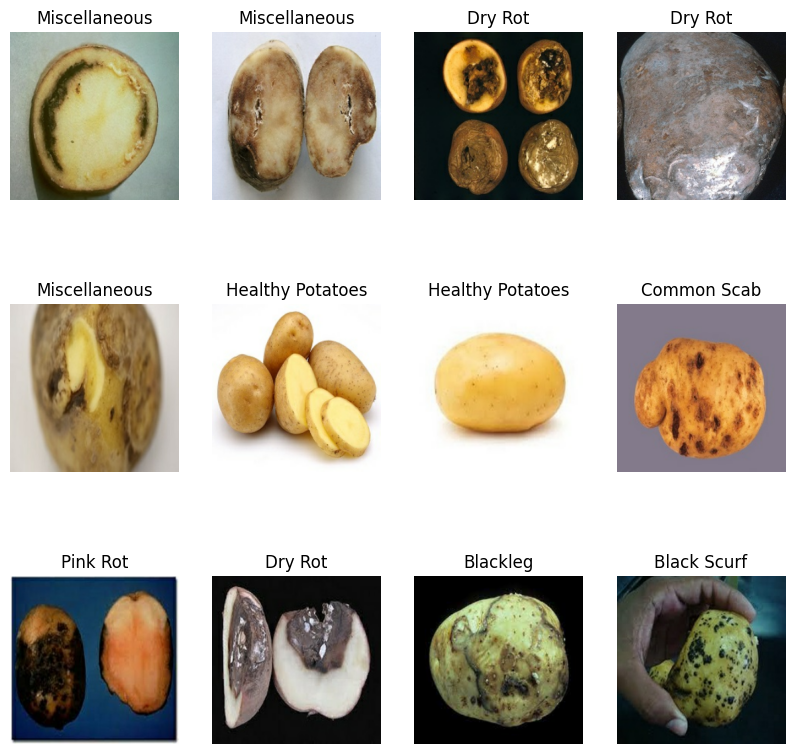

In [34]:
plt.figure(figsize=(10,10))
for img , label in potato_data.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(Class[label[i]])
    plt.axis("off")

shape of class names and img

In [35]:
for img, label in potato_data.take(1):
  print(img.shape)
  print(label.numpy())


(30, 255, 255, 3)
[4 2 1 4 4 5 4 1 4 5 5 6 2 4 5 1 0 6 2 0 0 4 5 1 5 5 0 1 1 5]


Splitting Dataset :<br>
Train = 80%<br>
Test = 10%<br>
Val = 10 %


In [36]:
#training data
train_size = int(len(potato_data)*0.8)
Train_Data = potato_data.take(train_size)

In [37]:
#test data
test_size = int(len(potato_data)*0.1)
Test_Data = potato_data.skip(train_size).take(test_size)

In [38]:
#val data
val_size = int(len(potato_data)*0.1)
Val_Data = potato_data.skip(train_size+test_size).take(val_size)

In [39]:
#All Sets
print(f"Train Batches : {Train_Data.cardinality().numpy()}")
print(f"Test Batches : {Test_Data.cardinality().numpy()}")
print(f"Val Batches : {Val_Data.cardinality().numpy()}")


Train Batches : 12
Test Batches : 1
Val Batches : 1


.cache() → keeps data in memory (or disk) after first epoch → faster training.

.shuffle(999) → randomizes order with buffer size 999. Good for training.

.prefetch(buffer_size=tf.data.AUTOTUNE) → overlaps preprocessing + model execution, speeds pipeline.

In [40]:
Train_ds = Train_Data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_ds = Test_Data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_ds = Val_Data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

  Resize and Rescale Layer

In [41]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
])

Data Augmantaion Layer

In [42]:
augmentated_data = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.5)
])

Build CNN network

In [43]:
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)


In [44]:
model = keras.models.Sequential([
    resize_and_rescale,
    augmentated_data,
    layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=INPUT_SHAPE,activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

     layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_class,activation="softmax")
])
model.build(input_shape=INPUT_SHAPE)


In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (30, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (30, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (30, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (30, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (30, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (30, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (30, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (30, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (30, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (30, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (30, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (30, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (30, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (30, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (30, 7)                │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,151 (1.06 MB)

 Trainable params: 278,151 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [47]:
history = model.fit(
    Train_ds,
    validation_data = Val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    verbose=1
)

Epoch 1/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1528 - loss: 1.9623 - val_accuracy: 0.3333 - val_loss: 1.8709
Epoch 2/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1833 - loss: 1.9379 - val_accuracy: 0.3333 - val_loss: 1.8514
Epoch 3/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1833 - loss: 1.9223 - val_accuracy: 0.3667 - val_loss: 1.8014
Epoch 4/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2000 - loss: 1.8826 - val_accuracy: 0.4333 - val_loss: 1.6869
Epoch 5/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3028 - loss: 1.7593 - val_accuracy: 0.1667 - val_loss: 2.4087
Epoch 6/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3028 - loss: 1.7775 - val_accuracy: 0.4667 - val_loss: 1.2914
Epoch 7/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3472 - loss: 1.6327 - val_accuracy: 0.3333 - val_loss: 1.3602
Epoch 8/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3639 - loss: 1.6093 - val_accuracy: 0.5667 - v

In [53]:
model.evaluate(Test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7667 - loss: 0.5670


[0.5669682621955872, 0.7666666507720947]

Actual label Healthy Potatoes
Actual imageAxesImage(shape=(255, 255, 3))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Predicted label Healthy Potatoes


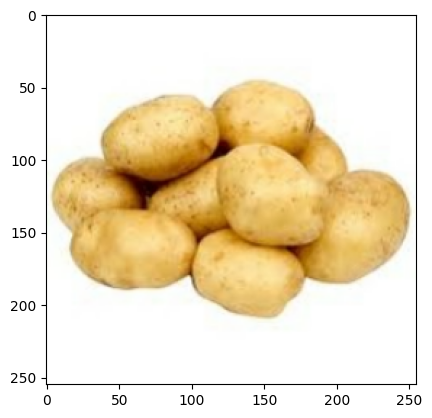

In [49]:
for img , label in Test_ds.take(1):

  first_img = img[16].numpy().astype("uint8")
  first_label = label[16].numpy()

  print(f"Actual label {Class[first_label]}")
  print(f"Actual image{plt.imshow(first_img)}")

  batch_pred = model.predict(img)
  print(f"Predicted label {Class[np.argmax(batch_pred[16])]}")

In [50]:
# After training your model
model.save("model_with_inference_1.keras", include_optimizer=True)

model.save("model_with_inference_2.h5", include_optimizer=True)



In [51]:
img_path = "C:\\Users\\Parth\\OneDrive\\Desktop\\college project final year\\GUI\\potata_data\\Dry Rot\\11.jpg"

img = tf.io.read_file(img_path)

# Decode to tensor
img = tf.image.decode_image(img, channels=3)

img = tf.image.resize(img, [255, 255])

img = img / 255.0

img = tf.expand_dims(img, 0)

pred = model.predict(img)
print(Class[np.argmax(pred)])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Miscellaneous


In [52]:
from PIL import Image
import numpy as np

img = Image.open("path/to/image.jpg")
img = img.resize((255, 255))  # same as training
img_array = np.array(img).astype('float32') / 255.0  # match training
img_array = np.expand_dims(img_array, 0)  # add batch dimension

pred = model.predict(img_array)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Parth\\OneDrive\\Desktop\\college project final year\\GUI\\path\\to\\image.jpg'